

---
### Chargmenet et Verification des images
Charger les images du dataset et vérifier leurs extensions (jpeg, jpg, bmp, png). Supprimer celles qui ne correspondent pas.


In [27]:
data_path = "data/data_blood_cell_cancer/" 


In [28]:
import os 

# data path

data_path = "data/data_blood_cell_cancer/" 

folders = os.listdir(data_path)

invalid_files  = []
classesWithoutExt  = {}

filescounter =0

allowed_extensions = [".jpeg", ".jpg", ".bmp", ".png"]

for folder in folders:
    folder_path = os.path.join(data_path, folder)

    # Skip if not a directory
    if not os.path.isdir(folder_path):
        continue

    classesWithoutExt[folder]=0

    for file in os.listdir(folder_path):

        file_path = os.path.join(folder_path, file)
        name,ext = os.path.splitext(file)

        filescounter+=1

        try:
            if ext.lower() == "" or ext.lower() not in allowed_extensions:
                classesWithoutExt[folder]+=1
                invalid_files.append(file)
                
                print(f"Deleting file without extension: {file_path}")

                # data/folder/image
                # os.remove(file_path)
        except FileNotFoundError:
            print(f"Fichier introuvable : {file_path}")
        except Exception as e:
            print(f"Erreur inattendue avec {file_path}: {e}")



print("total files: ",filescounter)
print("files without extention ",len(invalid_files)) 
print(classesWithoutExt) 



total files:  3242
files without extention  0
{'Benign': 0, 'early Pre-B': 0, 'Pre-B': 0, 'Pro-B': 0}


---
images and lables extracting

In [29]:
import random
import cv2
import numpy as np

# folder path
data_path = "data/data_blood_cell_cancer/" 
folders = os.listdir(data_path)

images = []
labels = []

for folder in folders:

    folder_path = os.path.join(data_path, folder)
    if not os.path.isdir(folder_path):
        continue

    for file in os.listdir(folder_path):

        file_path = os.path.join(folder_path, file)

        try:
            # read images as color (BGR) and convert to RGB
            image = cv2.imread(file_path, cv2.IMREAD_COLOR)  # returns (H, W, 3) in BGR

            # Check if image was loaded successfully
            if image is None:
                print(f"Warning: Could not load image {file_path}")
                continue

            # convert BGR to RGB
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # resize to 224x224
            # image = cv2.resize(image, (224, 224))

            # RGB images already have channel dimension (224, 224, 3)
            images.append(image)
            labels.append(folder)  # folder name is the label name

        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            continue

# -------------------------------------

# shuffling
# combined = list(zip(images, labels))
# random.shuffle(combined)
# images, labels = zip(*combined)  # unzip back to separate lists

# # Convert to list (zip returns tuples)
# images = list(images)
# labels = list(labels)

# # Convert to numpy array
# images = np.array(images)
# labels = np.array(labels)

# summary
print(f"Total images: {len(images)}")
print(f"Total labels: {len(labels)}")


Total images: 3242
Total labels: 3242


---
### Analyse 
Histogram +  Nombre d’échantillons dans chaque classe 

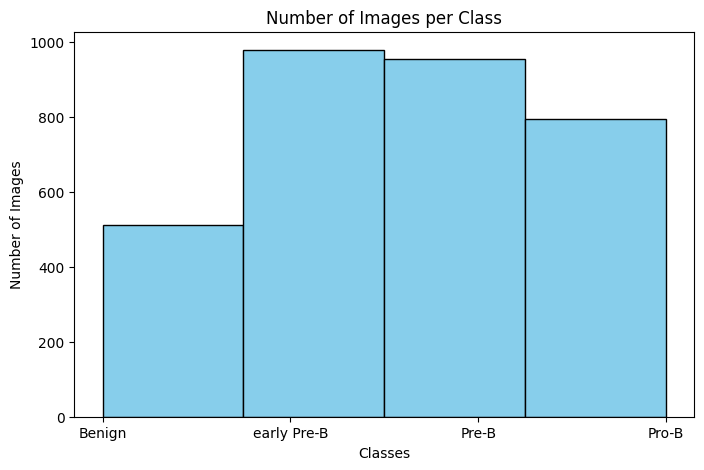

In [30]:
import matplotlib.pyplot as plt

categories_len = len(np.unique(labels))

plt.figure(figsize=(8,5))

plt.hist(labels, bins=categories_len, color='skyblue', edgecolor='black')
plt.title("Number of Images per Class")
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.show()




C:\Users\alibo\AppData\Local\Temp\ipykernel_34108\577838447.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='classe', data=df, palette='viridis',


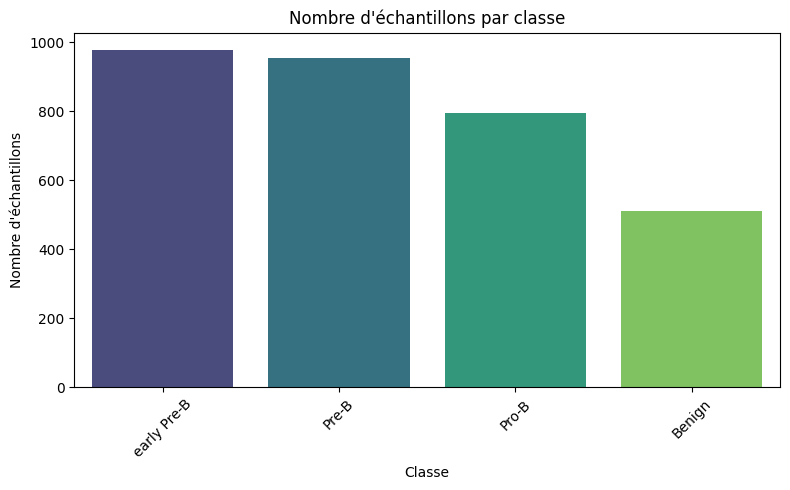

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


df = pd.DataFrame({'classe': labels})

plt.figure(figsize=(8,5))
sns.countplot(x='classe', data=df, palette='viridis',
              order=df['classe'].value_counts().index)  # optionnel: trier par fréquence
plt.title("Nombre d'échantillons par classe")
plt.xlabel("Classe")
plt.ylabel("Nombre d'échantillons")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [32]:
from collections import Counter

# Count the occurrences of each label
label_counts = Counter(labels) # key value par (categori + total of it)

# categories= pd.value_counts(labels) 
categories= pd.Series(labels).value_counts()
print(categories)

print("#"*50)
total_samples = sum(label_counts.values())

for label, count in label_counts.items():
    percentage = (count / total_samples) * 100
    print(f"{label}: {percentage:.2f}%")



early Pre-B    979
Pre-B          955
Pro-B          796
Benign         512
Name: count, dtype: int64
##################################################
Benign: 15.79%
early Pre-B: 30.20%
Pre-B: 29.46%
Pro-B: 24.55%


---
### Echantillon d’images

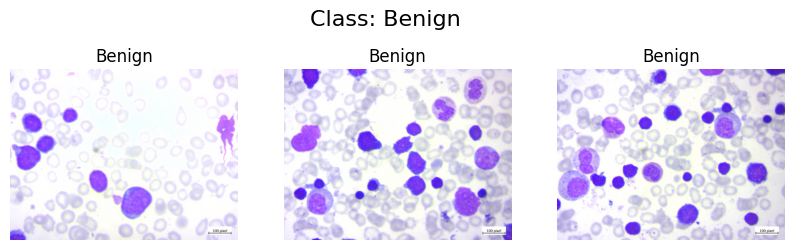

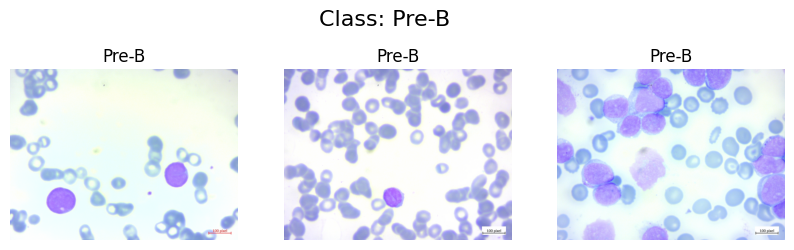

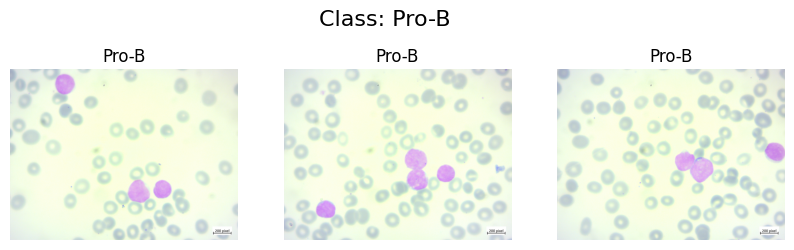

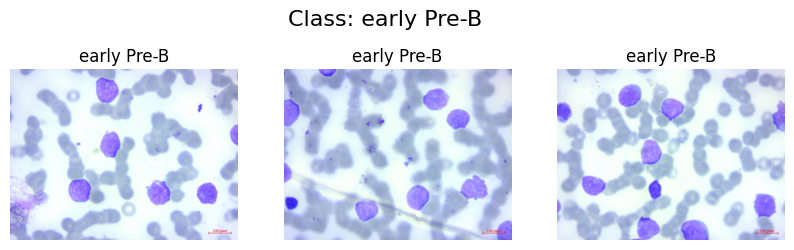

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# unique_classes -> list of all classes
unique_classes = np.unique(labels)

# Number of images per class to display
num_per_class = 3
labels = np.array(labels)  # ensure it's a NumPy array
labels = labels.flatten()  # now shape is (num_samples,)


for cls in unique_classes:
    # Find indices of images for this class
    cls_indices = np.where(labels == cls)[0]
    
    # Pick first 3 images (or random.sample if you want randomness)
    cls_indices = cls_indices[:num_per_class]
    
    plt.figure(figsize=(10,3))
    plt.suptitle(f"Class: {cls}", fontsize=16)
    
    for i, idx in enumerate(cls_indices):
        plt.subplot(1, num_per_class, i+1)
        plt.imshow(images[idx].squeeze(), cmap='gray')  # Better for medical images

        plt.title(str(cls))
        plt.axis('off')
    
    plt.show()


---
### Split data
Diviser les images en trois ensembles (dossiers) : Train, Validation et Test, selon la répartition suivante : 70 % pour l’entraînement, 15 % pour la validation et 15 % pour le test.

In [34]:
from sklearn.model_selection import train_test_split


# 1Séparer Train (70%) et le reste (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    images, labels, test_size=0.30, random_state=42, stratify=labels
)

# 2Séparer le reste en Validation (15%) et Test (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Train: {len(X_train)} images")
print(f"Validation: {len(X_val)} images")
print(f"Test: {len(X_test)} images")


Train: 2269 images
Validation: 486 images
Test: 487 images


---
- data augementation
- resize
- teurn to tensor flow
- nomalization
---

`transforms.ToTensor()`

**What it does:**

- Converts PIL Image or numpy array to PyTorch Tensor
- Changes data type from uint8 [0,255] to float32 [0.0, 1.0]
- Rearranges dimensions from (H, W, C) to (C, H, W) - PyTorch format

**Why use it:**

- PyTorch models expect tensors, not PIL Images
- Normalizes pixel values to [0,1] range
- Puts channel dimension first for efficient GPU processing

In [35]:
from torchvision.transforms import v2

# height and width
H, W = 128, 128

transforms = v2.Compose([
    # resize
    v2.Resize((H, W)),

    # data augmentation
    v2.RandomHorizontalFlip(p=0.5), # random flip
    v2.RandomRotation(degrees=15), # rotation
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # change brightness,dark light,make color muted
    
    # noise
    v2.GaussianNoise(mean=0.0, sigma=0.1), 


    # blur
    v2.RandomApply([
        v2.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
    ], p=0.3),

    # Convert to tensor
    v2.ToTensor(),

    # normalization
    v2.Normalize(
        mean=[0.485, 0.456, 0.406], # rgb mean
        std=[0.229, 0.224, 0.225] # rgb standard deviations
        ),
])


c:\Users\alibo\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [36]:
# using transforms in a loop is slow and memory intensive 
# use dataset

from PIL import Image
from torch.utils.data import Dataset

class BloodCellDataset(Dataset):
    def __init__(self, images, labels, transforms=None):
        self.images = images
        self.labels = labels
        self.transforms = transforms
        
        # Create label to index mapping
        self.label_to_idx = {label: idx for idx, label in enumerate(np.unique(labels))}
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        # Convert numpy array to PIL Image for transforms
        if isinstance(image, np.ndarray):
            # images are numpy arrays (h,w,c) but pytorch transforms expect PIL Images.
            image = Image.fromarray(image.astype('uint8'))

        if self.transforms:
            image = self.transforms(image)
            
        # Convert label to numeric
        label_idx = self.label_to_idx[label]
        
        return image, label_idx
    
# Validation/Test transforms (no augmentation, only normalization)
val_test_transforms = v2.Compose([
    v2.Resize((H, W)),
    v2.ToTensor(),
    v2.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

# Update dataset creation
train_dataset = BloodCellDataset(X_train, y_train, transforms)
val_dataset = BloodCellDataset(X_val, y_val, val_test_transforms)
test_dataset = BloodCellDataset(X_test, y_test, val_test_transforms)

print(f"Train dataset: {len(train_dataset)} samples")
print(f"Val dataset: {len(val_dataset)} samples") 
print(f"Test dataset: {len(test_dataset)} samples")


Train dataset: 2269 samples
Val dataset: 486 samples
Test dataset: 487 samples


In [37]:
from torch.utils.data import DataLoader

# Create data loaders
batch_size = 32

train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=2,
    pin_memory=True
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 71
Val batches: 16
Test batches: 16
